# Single-cell RNA-seq analysis workflow for 1M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

import utils

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
USE_FIRST_N_CELLS = 1000000

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training, when using batched PCA function
n_pca_batches = 10 # number of batches, when using batched PCA function

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 25s, sys: 5.2 s, total: 1min 30s
Wall time: 1min 29s


In [6]:
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1000000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

Trying to set attribute `.obs` of view, copying.


CPU times: user 1min 55s, sys: 36.7 s, total: 2min 31s
Wall time: 2min 31s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 23.9 s, sys: 9.56 s, total: 33.4 s
Wall time: 33.4 s


In [10]:
adata.shape

(989838, 23781)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 8.84 s, sys: 1 s, total: 9.84 s
Wall time: 9.82 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 30.6 s, sys: 1.48 s, total: 32 s
Wall time: 32 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].todense()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 33.3 s, sys: 1.48 s, total: 34.7 s
Wall time: 34.7 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 21.5 s, sys: 552 ms, total: 22.1 s
Wall time: 22.1 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 6h 46min 10s, sys: 1d 1h 31min 44s, total: 1d 8h 17min 54s
Wall time: 1h 1min 55s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 32.3 s, sys: 2.17 s, total: 34.5 s
Wall time: 34.5 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 4033.7670826911926


## Cluster & Visualize

### Reduce

First, we calculate the time taken to run PCA using the complete dataset.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 1h 3min 40s, sys: 22min 47s, total: 1h 26min 27s
Wall time: 2min 9s


For a fair comparison with the single-GPU notebook, we also calculate the time taken if we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [19]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 11min 58s, sys: 5min 44s, total: 17min 43s
Wall time: 34 s


### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 8h 56min 4s, sys: 18min 48s, total: 9h 14min 52s
Wall time: 1h 30min 17s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


CPU times: user 42min 21s, sys: 18min 48s, total: 1h 1min 10s
Wall time: 1min 46s


... storing 'kmeans' as categorical


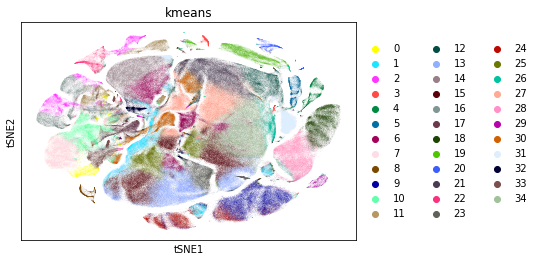

CPU times: user 7.01 s, sys: 967 ms, total: 7.98 s
Wall time: 7.96 s


In [22]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

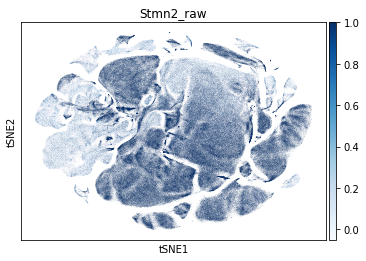

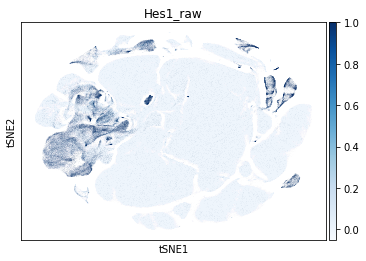

CPU times: user 6.88 s, sys: 0 ns, total: 6.88 s
Wall time: 6.86 s


In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Louvain

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 9min, sys: 47.2 s, total: 9min 47s
Wall time: 9min 45s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 5h 29min 58s, sys: 1h 57min 55s, total: 7h 27min 53s
Wall time: 29min 11s


In [26]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 9min 57s, sys: 983 ms, total: 9min 58s
Wall time: 9min 57s


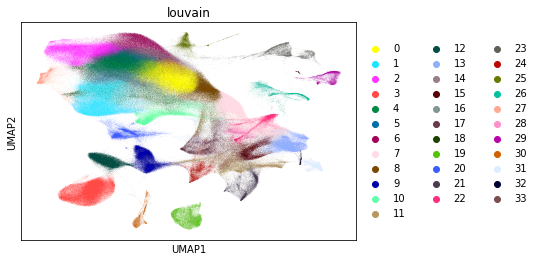

CPU times: user 6.51 s, sys: 165 ms, total: 6.68 s
Wall time: 6.67 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

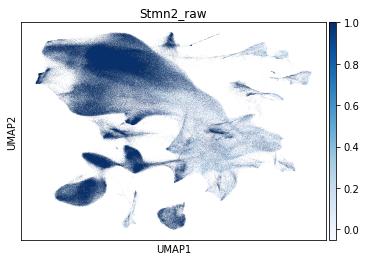

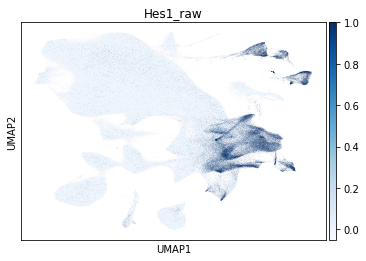

CPU times: user 6.6 s, sys: 212 ms, total: 6.81 s
Wall time: 6.81 s


In [28]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Create zoomed-in view

In [29]:
reanalysis_start = time.time()

In [30]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(95916, 4000)
CPU times: user 2.41 s, sys: 342 ms, total: 2.75 s
Wall time: 2.75 s


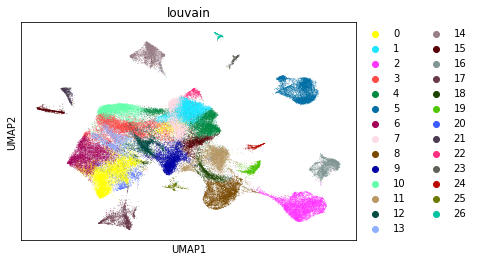

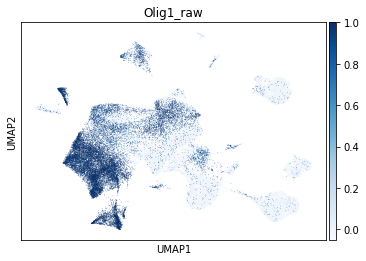

CPU times: user 27min 37s, sys: 18min 51s, total: 46min 28s
Wall time: 3min 47s


In [31]:
%%time

sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [32]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 230.1244809627533


In [33]:
print("Full time: %s" % (time.time() - start))

Full time: 13002.727365970612
